Comparing merge-tests between 3.6 revision r6036 and r5912 

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import datetime

from salishsea_tools import stormtools, nc_tools, viz_tools

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [3]:
#load in the datas. Trying something new with dict objects...

#first run 
r1 = 'r5912';
runname1 = '/ocean/sallen/allen/research/MEOPAR/myResults/merge-apr2016/r5912/'
print (runname1)

#second run 
r2 = 'r6036'
runname2 = ('/ocean/sallen/allen/research/MEOPAR/myResults/merge-apr2016/r6036/')
print (runname2)

runs = {r1: runname1, r2: runname2}


/ocean/sallen/allen/research/MEOPAR/myResults/merge-apr2016/r5912/
/ocean/sallen/allen/research/MEOPAR/myResults/merge-apr2016/r6036/


In [5]:
fUs={}; fVs={}; fTs={}
for key, path in runs.items():
    if key == r1:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_T.nc','r');
    else:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20160102_20160104_grid_T.nc','r');

Show info about the files

In [6]:
for key in runs:
    print (key)
    nc_tools.show_dataset_attrs(fUs[key])

r5912
file format: NETCDF4
name: SalishSea_1h_20160102_20160104
description: ocean U grid variables
title: ocean U grid variables
Conventions: CF-1.5
production: An IPSL model
timeStamp: 2016-May-14 16:38:32 PDT
history: Sun May 15 10:44:49 2016: ncks -4 -L4 -O SalishSea_1h_20160102_20160104_grid_U.nc SalishSea_1h_20160102_20160104_grid_U.nc
NCO: "4.5.2"
r6036
file format: NETCDF4
name: SalishSea_1h_20160102_20160104
description: ocean U grid variables
title: ocean U grid variables
Conventions: CF-1.5
production: An IPSL model
timeStamp: 2016-Jul-09 21:55:23 PDT


In [7]:
for key in runs:
    print (key)
    nc_tools.show_variable_attrs(fUs[key])

r5912
<class 'netCDF4._netCDF4.Variable'>
float32 depthu(depthu)
    long_name: Vertical U levels
    units: m
    axis: Z
    positive: down
    bounds: depthu_bounds
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 depthu_bounds(depthu, axis_nbounds)
unlimited dimensions: 
current shape = (40, 2)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 nav_lat(y, x)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    nav_model: grid_U
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 nav_lon(y, x)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    nav_model: grid_U
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.969209968386869e+36 use

Both have 60 time steps

In [8]:
#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}; Ds={}
tims = {}
t_orig = {}
tim_count={}

for key in runs:
    Us[key] = fUs[key].variables['vozocrtx']
    Vs[key] = fVs[key].variables['vomecrty']
    Es[key] = fTs[key].variables['sossheig']
    Ss[key] = fTs[key].variables['vosaline']
    Ts[key] = fTs[key].variables['votemper']
    Ds[key] = fTs[key].variables['deptht']
    tim_count[key] = fUs[key].variables['time_counter']
    
t_orig[r1] = datetime.datetime.strptime(
                    tim_count[r1].time_origin.title(), '%Y-%m-%d %H:%M:%S')
t_orig[r2] = datetime.datetime.strptime(
                tim_count[r2].time_origin.title(), '%Y-%m-%d %H:%M:%S')


### Comparison plots

Quick look at surface fields near the start and at end of run

In [9]:
def plot_variable(t,depthlevel,var, var_name,vmin=-3,vmax=3,diffmin=-0.1, diffmax=0.1,figsize=(15,5),ssh_flag=False):
    #plot
    fig, axs=plt.subplots(1,3,figsize=figsize)
    for key,ax in zip(runs,axs[0:2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        if ssh_flag:
            mesh=ax.pcolormesh(var[key][t,:,:],vmin=vmin,vmax=vmax)
        else:
            mesh=ax.pcolormesh(var[key][t,depthlevel,:,:],vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
    ax=axs[2]
    if ssh_flag:
        diff = var[r1][t,:,:]-var[r2][t,:,:]
        print (var_name, 'max', np.max(var[r1][t,:,:]-var[r2][t,:,:]), 
               'min', np.min(var[r1][t,:,:]-var[r2][t,:,:]))
    else:
        diff = var[r1][t,depthlevel,:,:]-var[r2][t,depthlevel,:,:]
        print (var_name, 'max', np.max(var[r1][t, depthlevel, :, :]-var[r2][t, depthlevel, :, :]), 
               'min', np.min(var[r1][t, depthlevel, :, :] - var[r2][t, depthlevel, :, :]))
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap = 'bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)

Initial time, surface

Time = 0, depth level = 0
U [m/s] max 0.000913531 min -0.000442974
V [m/s] max 0.00293612 min -0.00235576
SSH [m] max 6.6556e-05 min -9.75803e-05
Sal [g/kg] max 0.013327 min -7.62939e-05
Temp [deg C] max 0.045661 min -0.00214934


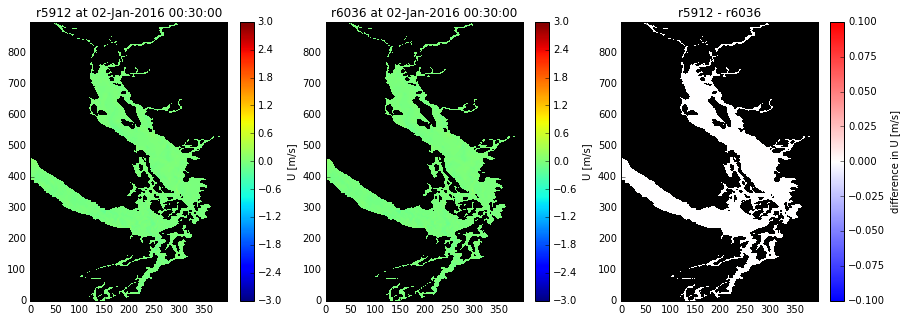

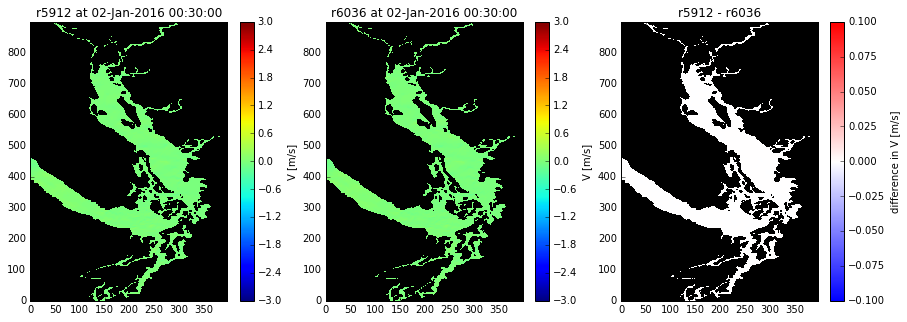

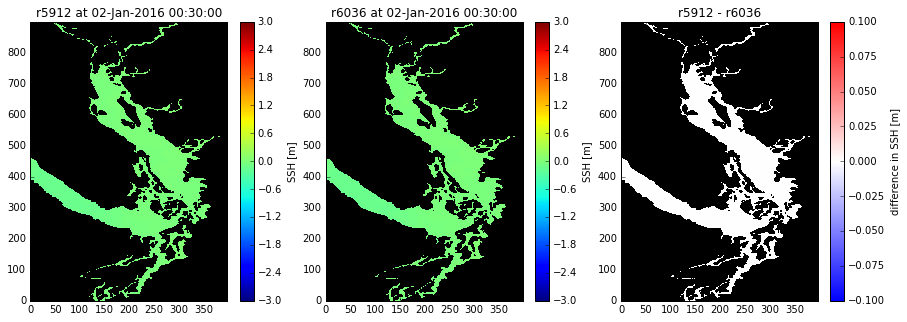

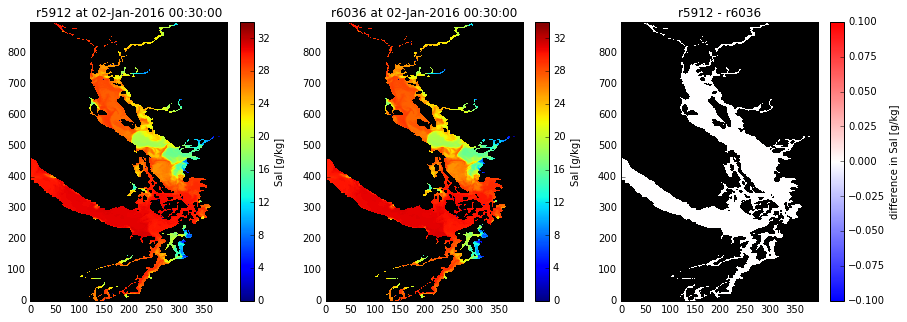

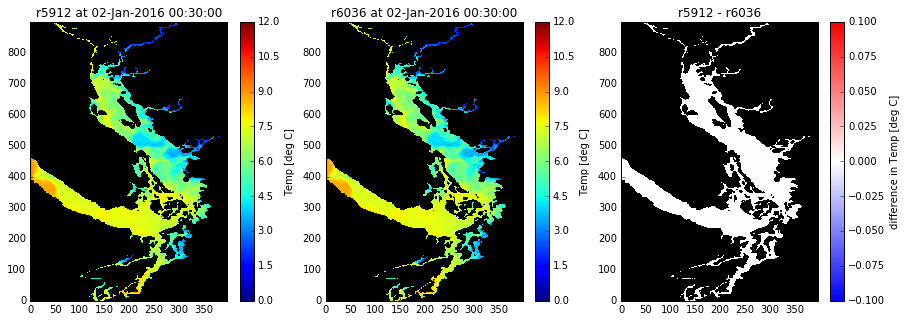

In [10]:
t=0
depthlevel=0

print ('Time = {}, depth level = {}'.format(t,depthlevel))
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [g/kg]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

No significant differences at this early time.

Time = 63, depth level = 0
U [m/s] max 0.892279 min -0.654354
V [m/s] max 1.40238 min -0.790655
SSH [m] max 0.00908318 min -0.00909489
Sal [g/kg] max 7.02116 min -9.80554
Temp [deg C] max 1.50221 min -1.25152


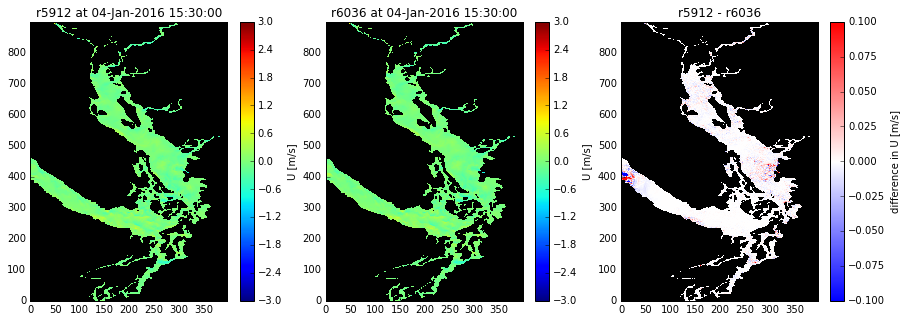

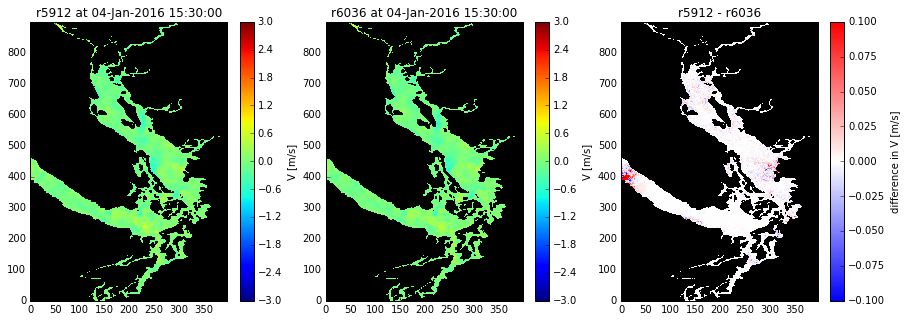

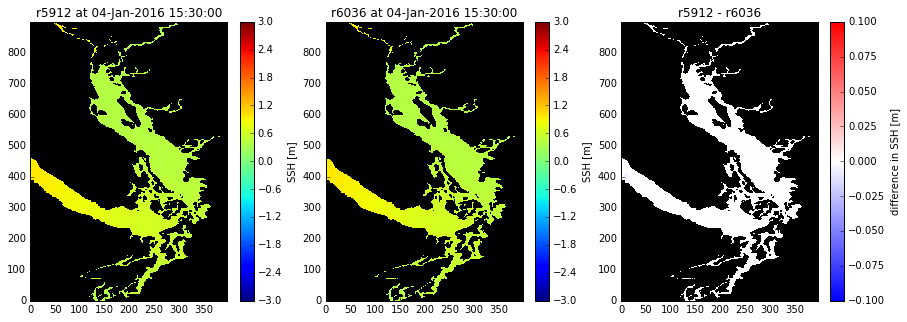

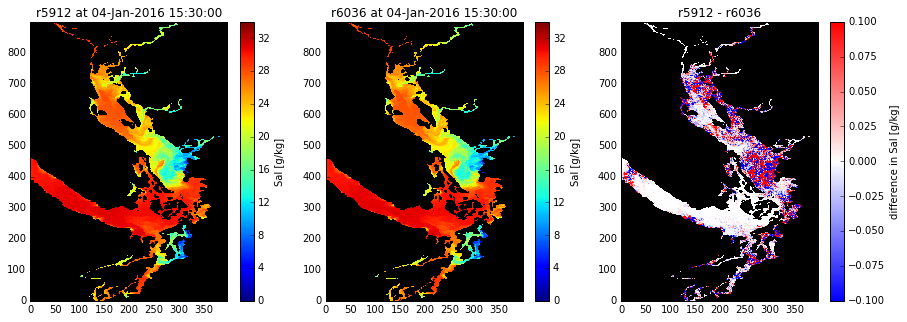

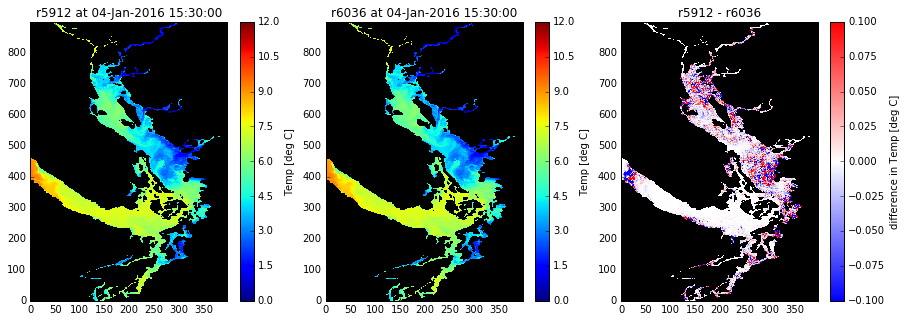

In [11]:
t = 63
depthlevel = 0

print ('Time = {}, depth level = {}'.format(t,depthlevel))
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [g/kg]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

* big differences except in ssh: focussed at mouth of Juan de Fuca and in the plume region

# Profiles

In [12]:
def compare_profile(var,var_name, i,j,t,zmin=0,zmax=400,vmin=0,vmax=34):
    """Function to compare a variable over depth at point i,j and time t.
    Plots each sim on the same axis and then their difference over depth"""

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    for key in runs:
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        ax.plot(var[key][t,:,j,i],Ds[key], '-o',label=key)
    ax.set_title(out.strftime('%d-%b-%Y %H:%M:%S'))
    ax.set_xlabel(var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])
    ax.set_xlim([vmin,vmax])
    ax.legend(loc=0)
    ax=axs[1]
    #difference    
    diff = var[r1][t,:,j,i]-var[r2][t,:,j,i]
    ax.plot(diff,Ds[key], '-ro')
    ax.set_title('Difference: ' +r1+' - ' +r2)
    ax.set_xlabel('Difference in ' + var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])

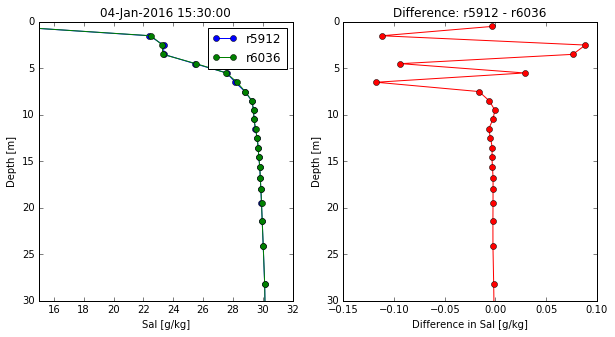

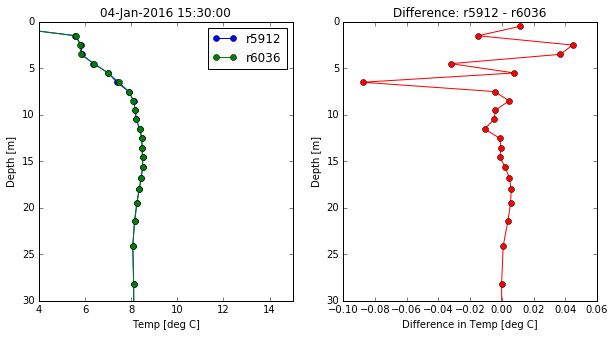

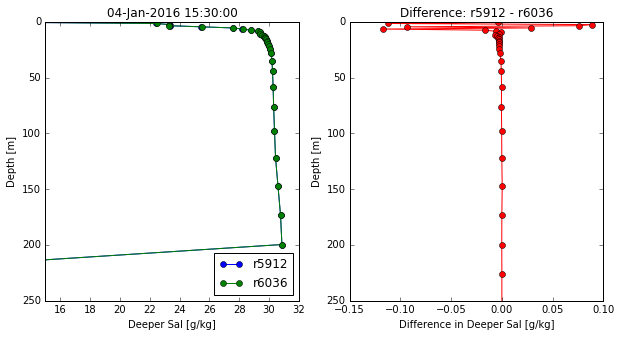

In [13]:
tp = t
ip = 300
jp = 450
zmax= 30
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=4,vmax=15)
zmax=250
compare_profile(Ss,'Deeper Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)


* Central SoG

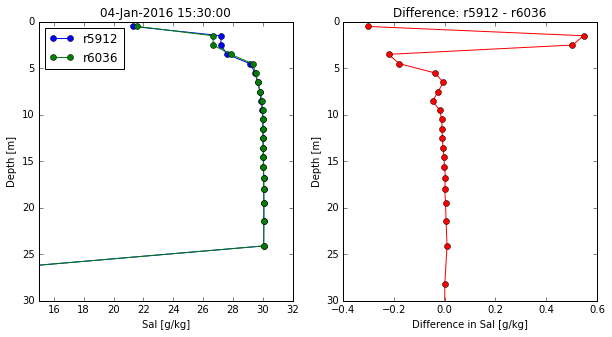

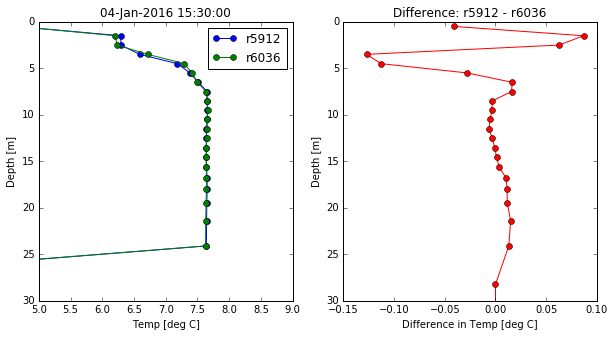

In [14]:
tp = t
ip = 300
jp = 400
zmax=30
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=5,vmax=9)


* Closer to Boundary Pass

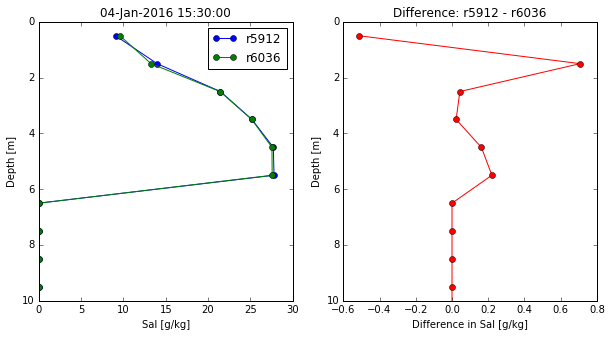

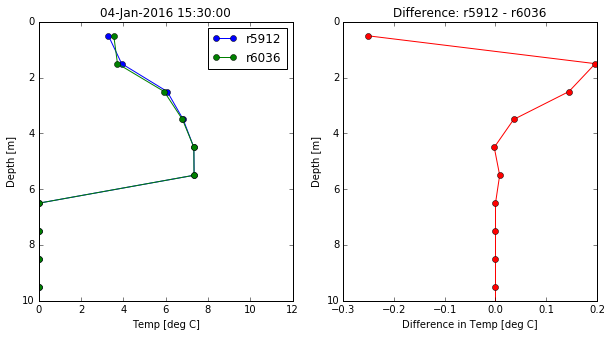

In [15]:
tp = t
ip = 310
jp = 430
zmax=10
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=0,vmax=30)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=0,vmax=12)

* r6036 shows a bit more near surface mixing

## Differences

Calculate simple staistics on the differences between fields. min/max/mean...

In [21]:
def summarize_differences(var, var_name, imin=0, imax=396, jmin=0, jmax=896, ts=64):
    diff = var[r1][0:ts,...,jmin:jmax+1,imin:imax+1]-var[r2][...,jmin:jmax+1,imin:imax+1]
    inds_min = np.argmin(diff); inds_min=np.unravel_index(inds_min,diff.shape)
    inds_max = np.argmax(diff); inds_max=np.unravel_index(inds_max,diff.shape)
    print (var_name)
    print ('min diff: {0:.3}, index {1}'.format(diff.min(),inds_min))
    print ('max diff: {0:.3}, index {1}'.format(diff.max(),inds_max))
    print ('mean diff {0:.3}'.format(diff.mean()))

In [22]:
variables = {'U [m/s]': Us,  'V [m/s]': Vs, 'SSH [m]': Es, 'Sal [psu]': Ss, 'Temp [deg C]': Ts}
for key in variables:
    summarize_differences(variables[key], key, ts=64)

U [m/s]
min diff: -1.3, index (54, 0, 402, 1)
max diff: 1.1, index (51, 0, 397, 1)
mean diff -5.55e-06
Sal [psu]
min diff: -12.2, index (61, 0, 437, 317)
max diff: 9.13, index (60, 0, 264, 136)
mean diff 7.81e-06
SSH [m]
min diff: -0.0152, index (55, 391, 6)
max diff: 0.0184, index (47, 416, 348)
mean diff 4.62e-07
V [m/s]
min diff: -2.09, index (54, 7, 403, 1)
max diff: 2.0, index (55, 0, 396, 1)
mean diff 1.1e-05
Temp [deg C]
min diff: -1.74, index (41, 2, 114, 166)
max diff: 2.24, index (40, 2, 114, 165)
mean diff -6.93e-06


* Diffs near western boundary, (U, V, SSH min)
* in Puget Sound (T)
* Stong flow region (S, SSH max)

### Boundary conditions on SSH

How do the ssh/u/v near the boundaries compare?

In [23]:
sshs={}
us={}
vs={}
i=1
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
        

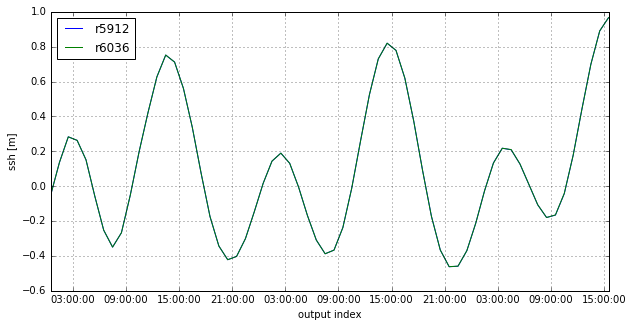

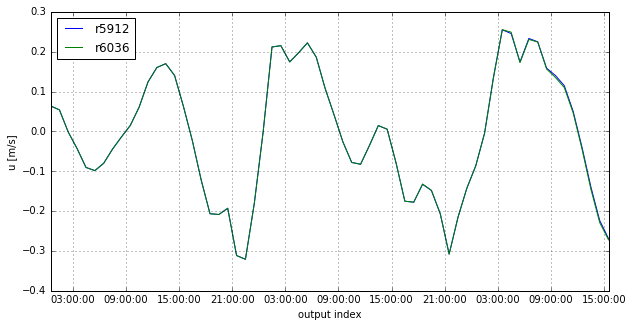

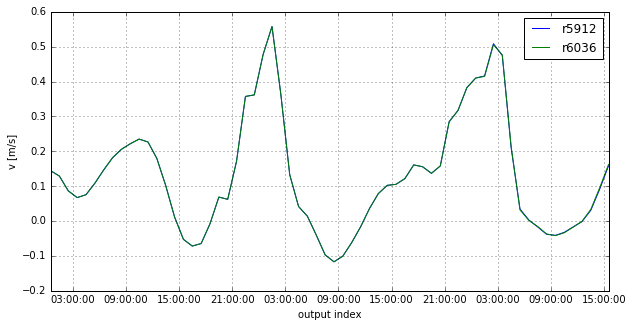

In [24]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()


Next to boundary

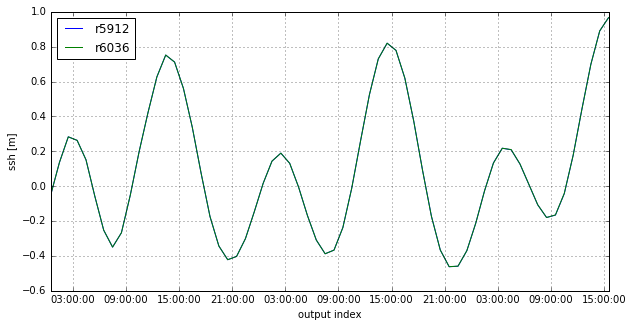

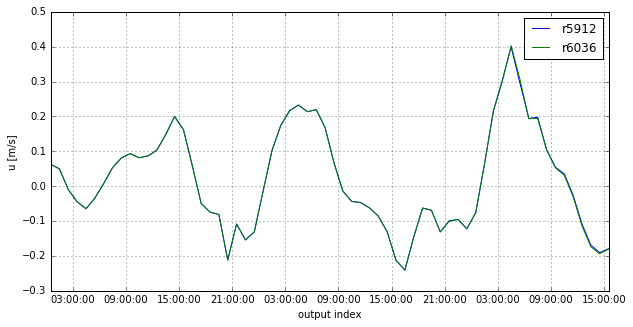

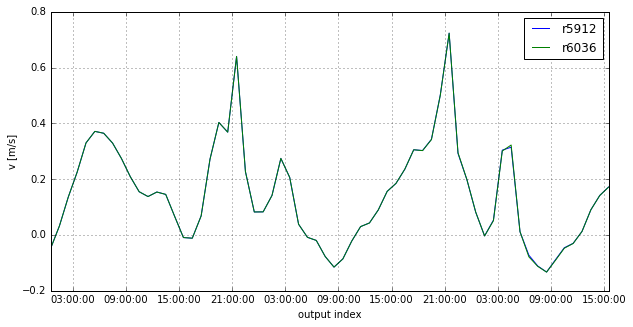

In [25]:
sshs={}
us={}
vs={}
i=2
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

North

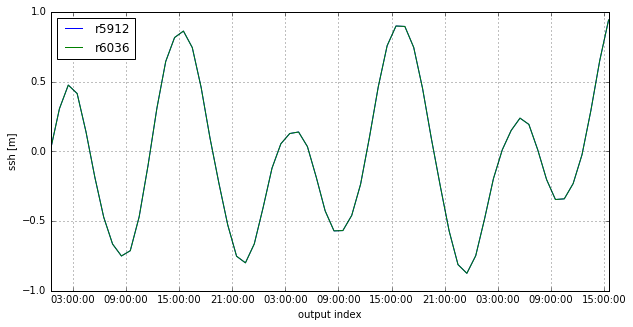

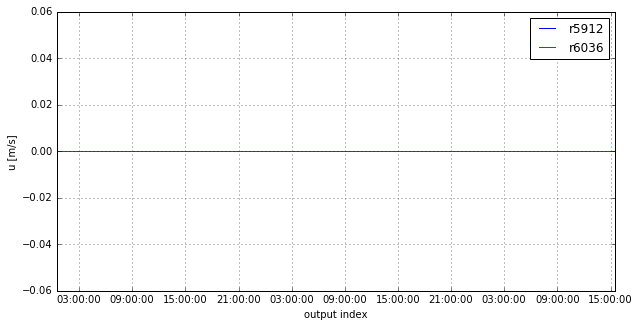

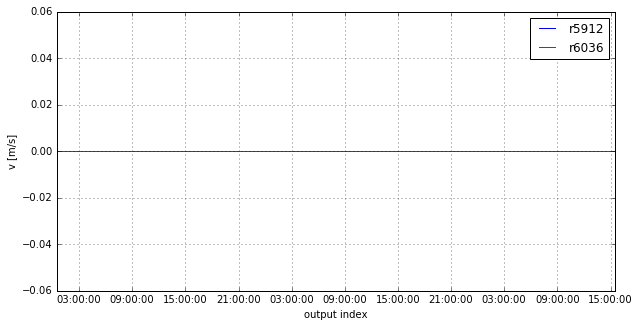

In [26]:
sshs={}
us={}
vs={}
i=50
j=896
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

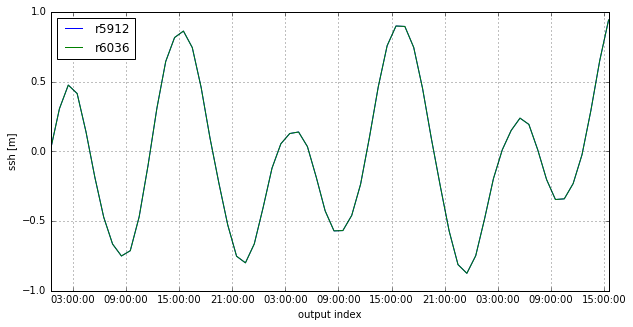

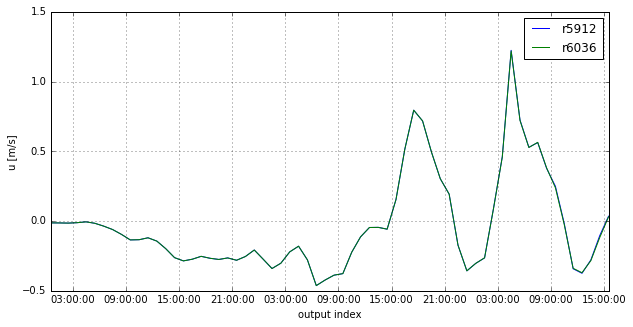

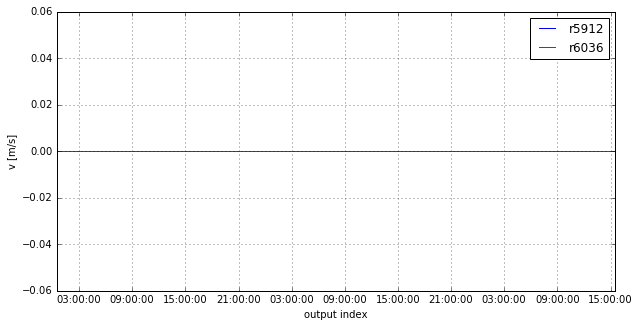

In [27]:
sshs={}
us={}
vs={}
i=50
j=895
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Phases align!

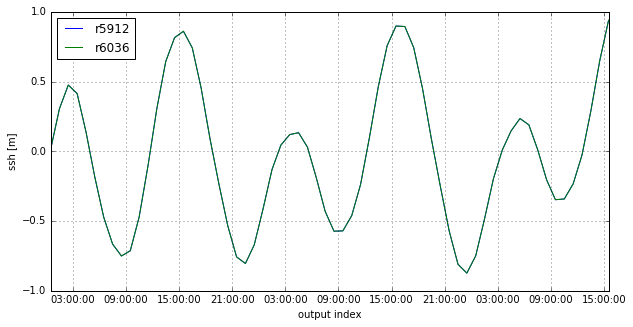

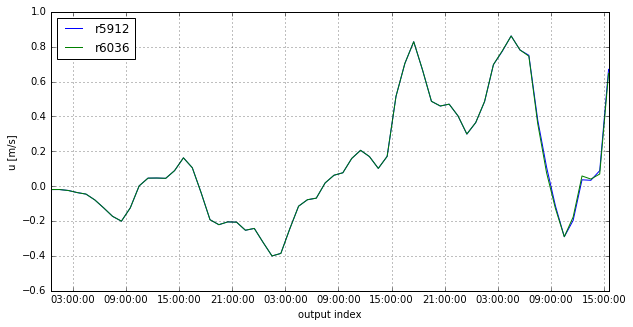

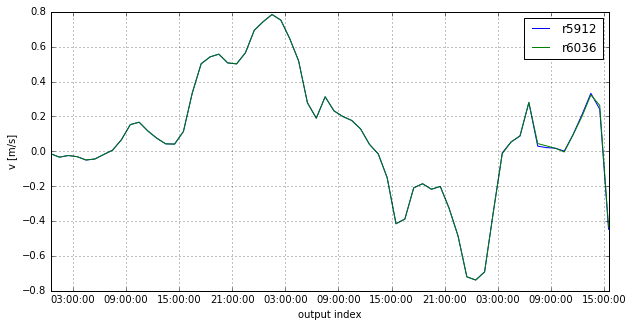

In [28]:
sshs={}
us={}
vs={}
i=50
j=894
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

# Closer look at currents at JdFS boundary

Compare fields over depth and along the JdF boundary

In [29]:
def compare_boundary(var, var_name, irange, jrange, t,vmin=-1,vmax=1,diffmin=-0.5,diffmax=0.5):
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    
    for ax, key in zip(axs[0:2],[r1,r2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        masked_var = np.ma.masked_values(var[key][t,:,jrange,irange],0)
        mesh=ax.pcolormesh(masked_var,vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        ax.invert_yaxis()

    ax=axs[2]
    diff = var[r1][t,:,jrange,irange]-var[r2][t,:,jrange,irange]
    diff=np.ma.masked_values(diff,0)
    mesh = ax.pcolormesh(diff,vmin=diffmin,vmax=diffmax)
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    ax.invert_yaxis()

Early time

Mouth of JdF at t = 0


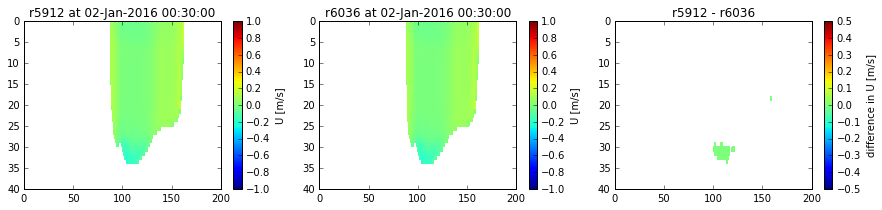

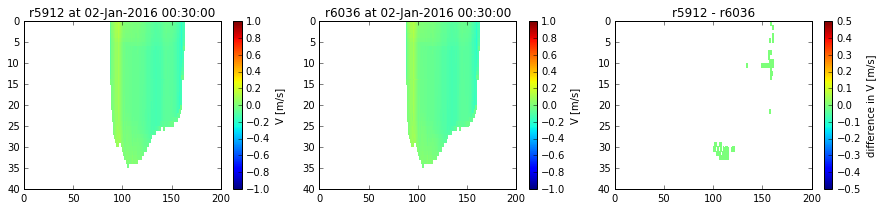

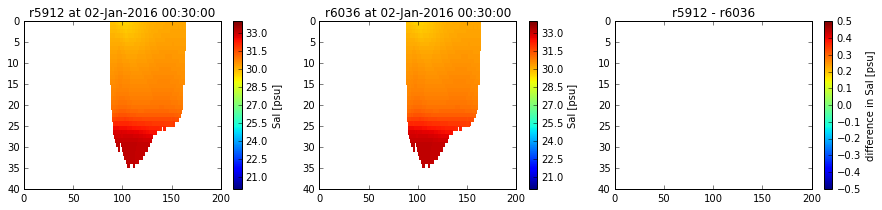

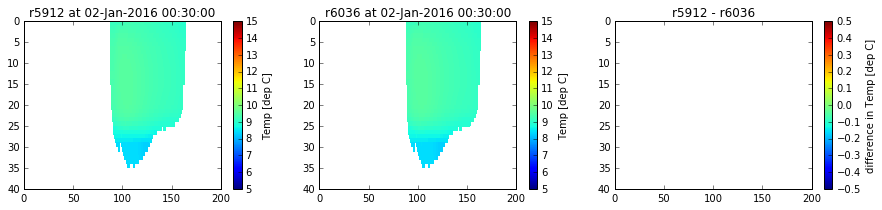

In [30]:
t=0
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print ('Mouth of JdF at t = {}'.format(t))

Max difference time

Mouth of JdF at t = 54


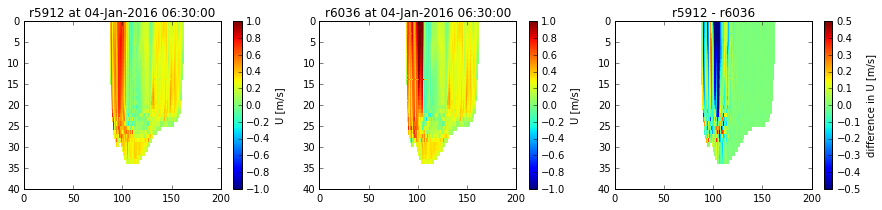

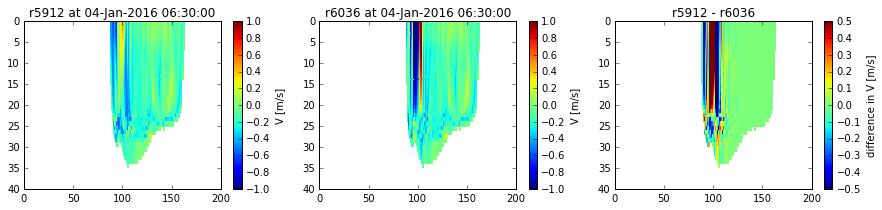

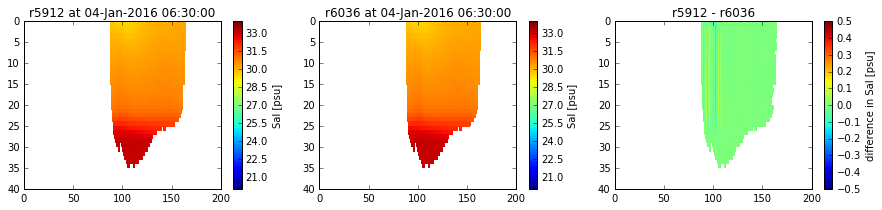

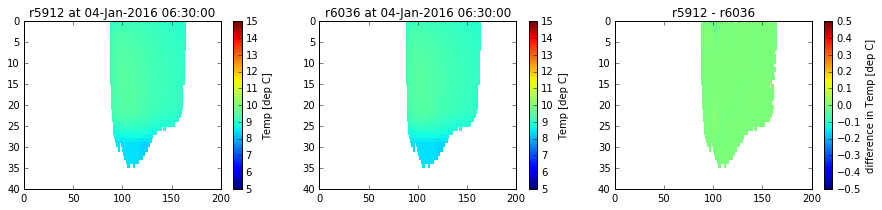

In [31]:
t=54
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print ('Mouth of JdF at t = {}'.format(t))

Last time

Mouth of JdF at t = 63


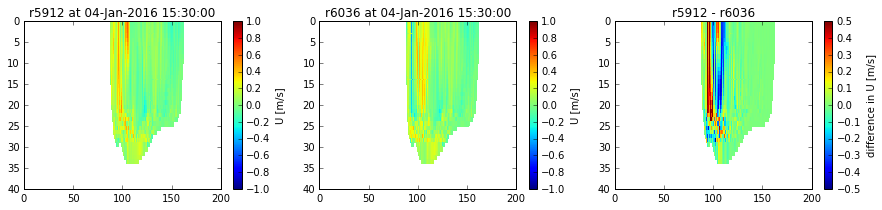

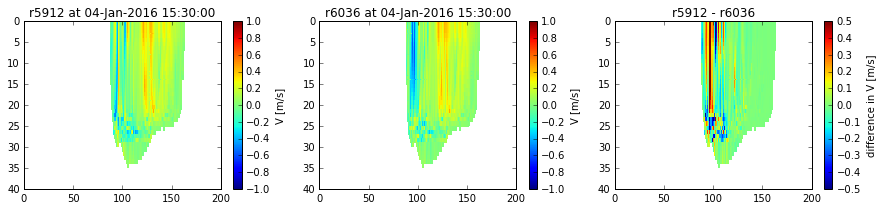

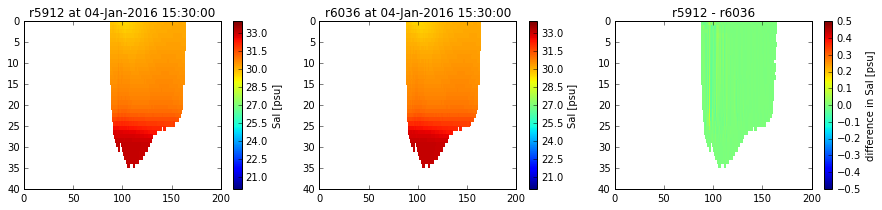

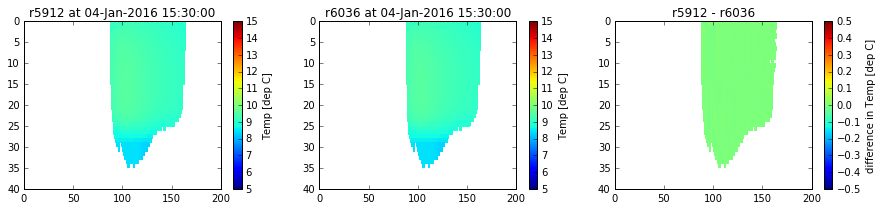

In [32]:
t=63
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print ('Mouth of JdF at t = {}'.format(t))

## Thalwegs

In [33]:
from salishsea_tools import visualisations as vis

In [39]:
print (Ss[r1])
mesh_mask = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone.nc')

<class 'netCDF4._netCDF4.Variable'>
float32 vosaline(time_counter, deptht, y, x)
    standard_name: sea_water_practical_salinity
    long_name: salinity
    units: 1e-3
    online_operation: average
    interval_operation: 40 s
    interval_write: 1 h
    cell_methods: time: mean (interval: 40 s)
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered deptht nav_lon nav_lat
unlimited dimensions: time_counter
current shape = (64, 40, 898, 398)
filling on


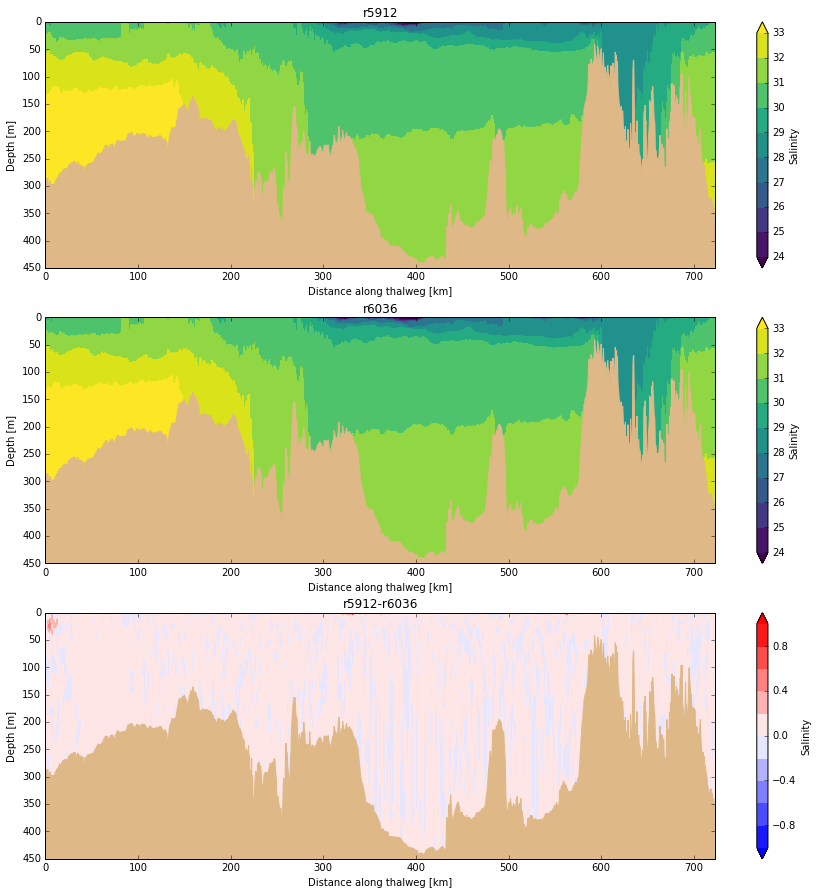

In [45]:
fig,ax = plt.subplots(3,1,figsize=(15,15))
clevels = np.arange(24., 34., 1)

cbar = vis.contour_thalweg(ax[0], Ss[r1][63], bathy, X, Y, mesh_mask, 'gdept_0', clevels, cmap='viridis')
ax[0].set_ylim([450,0])
cbar.set_label('Salinity')
ax[0].set_title(r1)

cbar = vis.contour_thalweg(ax[1], Ss[r2][63], bathy, X, Y, mesh_mask, 'gdept_0', clevels, cmap='viridis')
ax[1].set_ylim([450,0])
cbar.set_label('Salinity')
ax[1].set_title(r2)

clevels = np.arange(-1., 1.2, 0.2)
cbar = vis.contour_thalweg(ax[2], Ss[r1][63]-Ss[r2][63], bathy, X, Y, mesh_mask, 'gdept_0', clevels, 
                           cmap='bwr')
ax[2].set_ylim([450,0])
cbar.set_label('Salinity')
ax[2].set_title(r1+"-"+r2)

Interesting that the strongest differences are near the mouth.